<h1>Содержание<span class="tocSkip"></span></h1>
<li><span><a href="#Загрузка-и-подготовка" data-toc-modified-id="Загрузка-и-подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Проверка-структуры-и-пропусков" data-toc-modified-id="Проверка-структуры-и-пропусков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка структуры и пропусков</a></span></li><li><span><a href="#Визуализации" data-toc-modified-id="Визуализации-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Визуализации</a></span></li><li><span><a href="#Декомпозиция-ряда" data-toc-modified-id="Декомпозиция-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Декомпозиция ряда</a></span></li><li><span><a href="#Ананлиз-выбросов-и-создание-признаков" data-toc-modified-id="Ананлиз-выбросов-и-создание-признаков-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Ананлиз выбросов и создание признаков</a></span></li></ul></li><li><span><a href="#Корреляционный-анализ-и-создание-признаков" data-toc-modified-id="Корреляционный-анализ-и-создание-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Корреляционный анализ и создание признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
%matplotlib inline

# стандартные библиотеки
import numpy as np
import pandas as pd

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# анализ временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# модели машинного обучения
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# инструменты для оценки и предобработки моделей
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# статистический анализ
from statsmodels.stats.outliers_influence import variance_inflation_factor

# константы
RANDOM_STATE = 42
TEST_SIZE = 0.1
plt.rcParams['figure.dpi'] = 100

## Загрузка и подготовка

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=['datetime'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


None

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


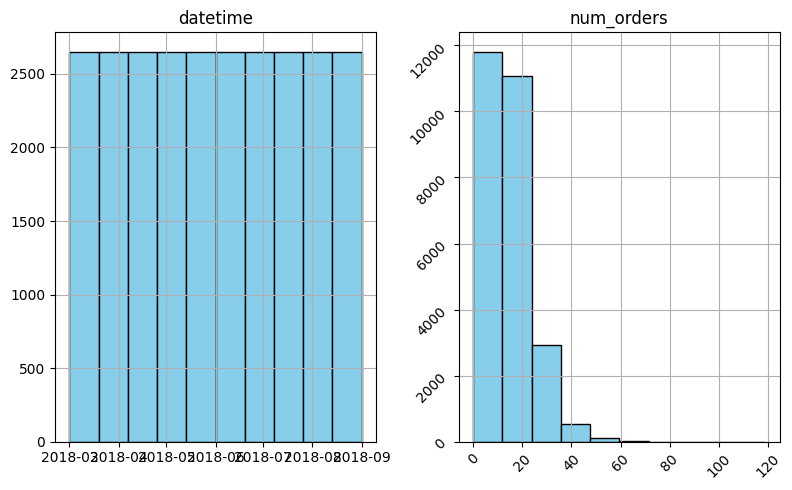

In [3]:
def check_df(df):
    display(df.info())
    display(df.head())
    display(df.describe())

    df.hist(figsize=(8,5), color='skyblue', edgecolor='black')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

    print()

check_df(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


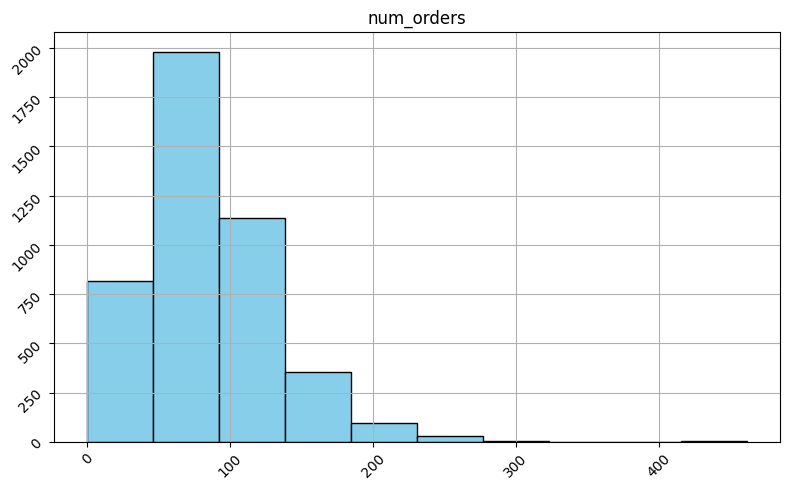

In [4]:
# Ресемплирование данных
df = df.resample('1h', on='datetime').sum()
check_df(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Выводы:
- До ресемплирования
    - Датасет загружен из `/datasets/taxi.csv` (26,496 строк, столбцы: `datetime`, `num_orders`).
    - `datetime` преобразован в `datetime64[ns]`, пропусков нет.
    - Временной диапазон: 2018-03-01 00:00:00 — 2018-08-31 23:50:00, гранулярность — 10 минут.
    - Статистика `num_orders`: среднее 14.07, медиана 13, минимум 0, максимум 119 (потенциальный выброс).
    - Гистограмма подтверждает левое смещение распределения, возможны выбросы.


- После ресемплирования  
    - Данные ресемплированы по часу, получено 4,416 строк.
    - Временной диапазон: 2018-03-01 00:00:00 — 2018-08-31 23:00:00.
    - `num_orders` агрегирован суммированием, максимум > 400 заказов/час.

## Исследовательский анализ данных

Цели EDA:
- Провести исследовательский анализ данных (EDA) для понимания структуры временного ряда, выявления трендов, сезонности, аномалий и других закономерностей.
- Сформировать гипотезы для создания признаков и выбора моделей.

### Проверка структуры и пропусков

Подтвердим отсутствие пропусков, проверим частоту индекса, проверим данные на наличие явных дубликатов после ресемплирования.

In [6]:
print('\nПропуски:\n', df.isna().sum())
print('\nЧастота индекса:', df.index.freq)
print('\nВременной диапазон:', df.index.min(), '—', df.index.max())
print('\nДубоикаты:', df.index.duplicated().sum())


Пропуски:
 num_orders    0
dtype: int64

Частота индекса: <Hour>

Временной диапазон: 2018-03-01 00:00:00 — 2018-08-31 23:00:00

Дубоикаты: 0


- Частота: 1 час.
- Пропусков нет, временной диапазон: 2018-03-01 00:00:00 — 2018-08-31 23:00:00.
- Частота индекса подтверждена ('H').
- Явных дубликатов нет.

### Визуализации

Построим графики для оценки трендов, сезонности и выбросов.

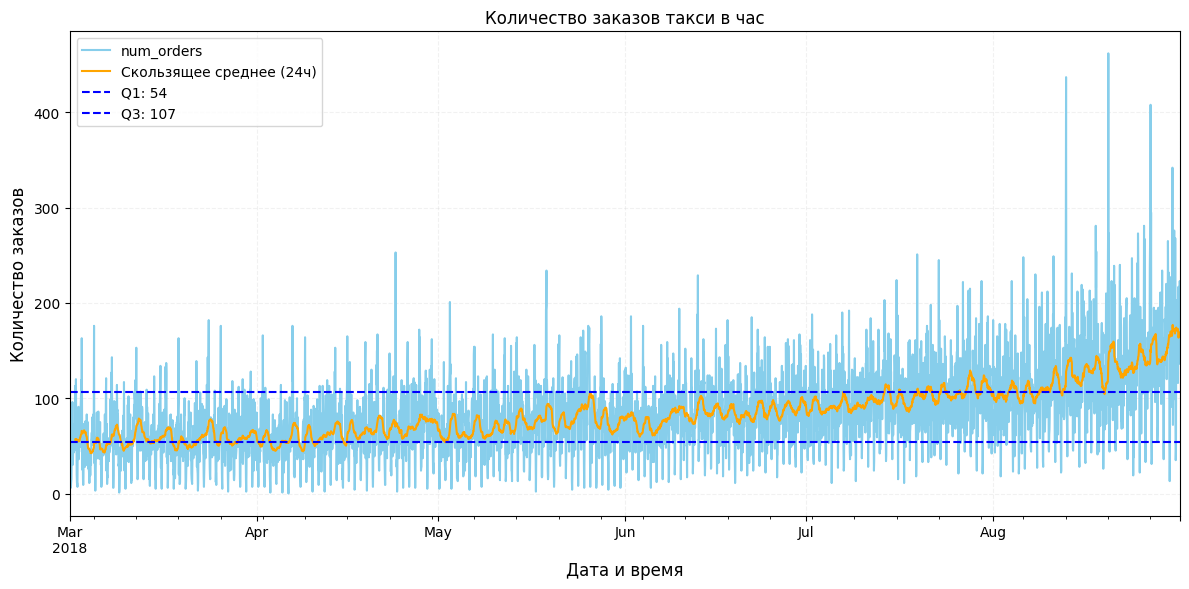

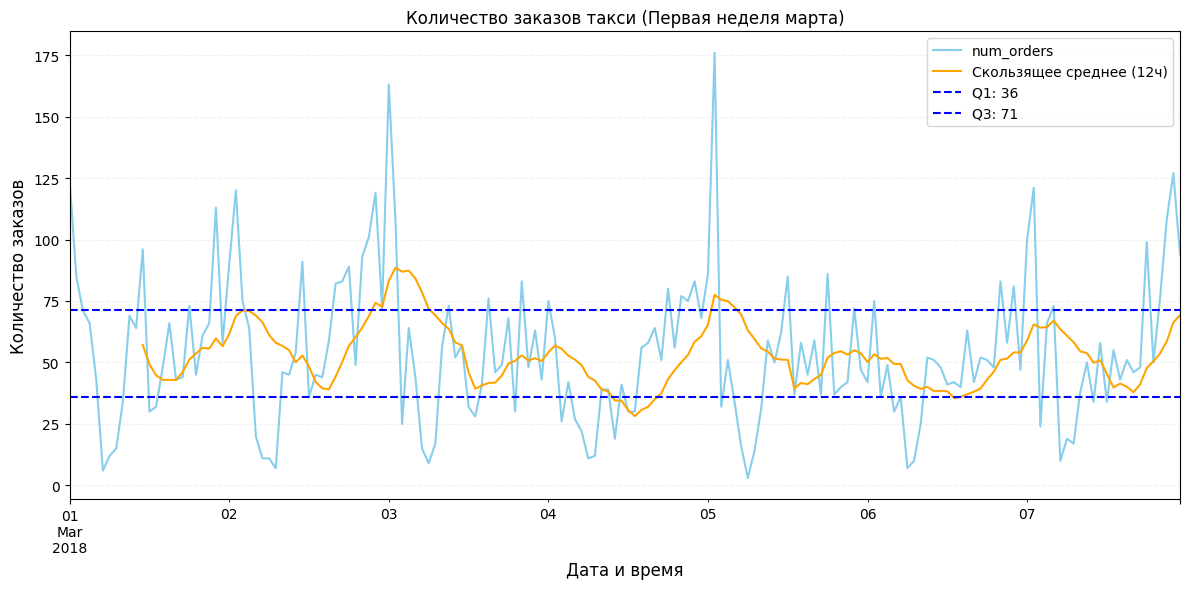

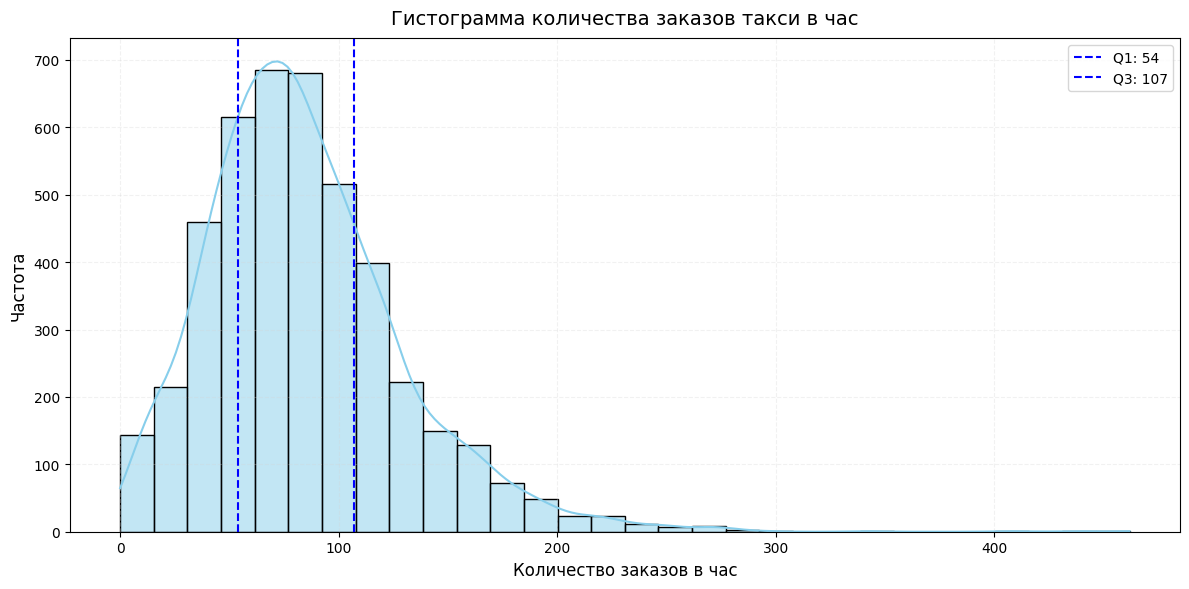

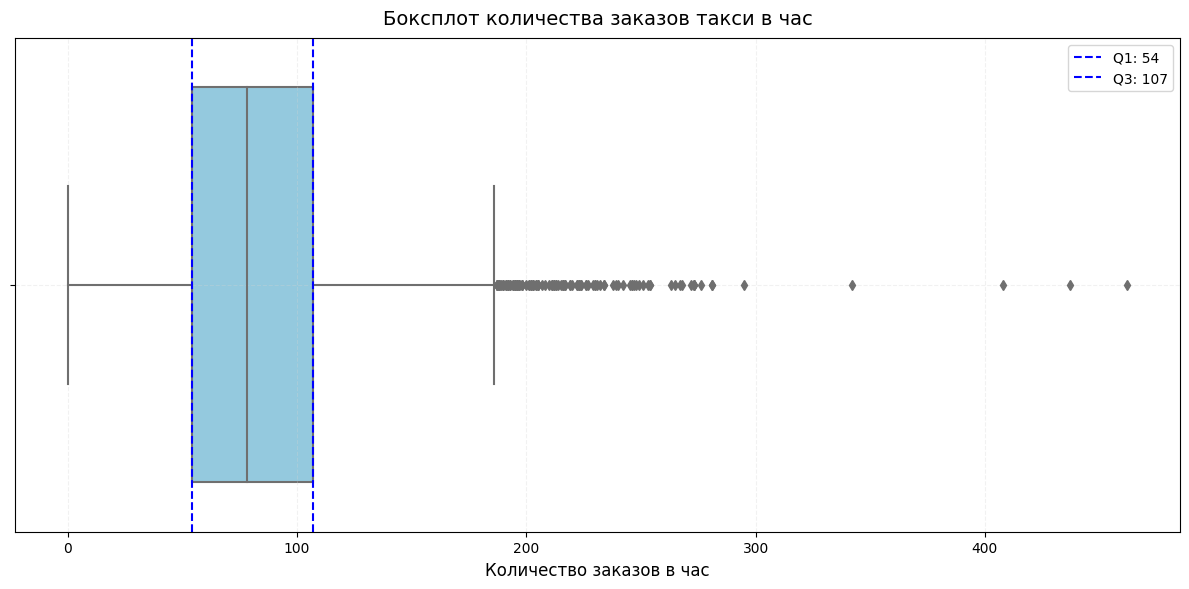

In [7]:
# график всего временного ряда
plt.figure(figsize=(12, 6))
df['num_orders'].plot(title='Количество заказов такси в час', color='skyblue')
# добавление скользящего среднего (24 часа)
df['num_orders'].rolling(window=24).mean().plot(color='orange', label='Скользящее среднее (24ч)')
# вычисление и добавление IQR
Q1 = df['num_orders'].quantile(0.25)
Q3 = df['num_orders'].quantile(0.75)
plt.axhline(Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.0f}')
plt.axhline(Q3, color='blue', linestyle='--', label=f'Q3: {Q3:.0f}')
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, color='#D3D3D3')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# график за неделю (для сезонности)
df_week = df['2018-03-01':'2018-03-07']
plt.figure(figsize=(12, 6))
df_week['num_orders'].plot(title='Количество заказов такси (Первая неделя марта)', color='skyblue')
# добавление скользящего среднего (12 часов)
df_week['num_orders'].rolling(window=12).mean().plot(color='orange', label='Скользящее среднее (12ч)')
# вычисление и добавление IQR
Q1_week = df_week['num_orders'].quantile(0.25)
Q3_week = df_week['num_orders'].quantile(0.75)
plt.axhline(Q1_week, color='blue', linestyle='--', label=f'Q1: {Q1_week:.0f}')
plt.axhline(Q3_week, color='blue', linestyle='--', label=f'Q3: {Q3_week:.0f}')
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, color='#D3D3D3')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# гистограмма с KDE
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='num_orders', bins=30, kde=True, color='skyblue')
# вычисление и добавление IQR
Q1 = df['num_orders'].quantile(0.25)
Q3 = df['num_orders'].quantile(0.75)
plt.axvline(Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.0f}')
plt.axvline(Q3, color='blue', linestyle='--', label=f'Q3: {Q3:.0f}')
plt.title('Гистограмма количества заказов такси в час', fontsize=14, pad=10)
plt.xlabel('Количество заказов в час', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, color='#D3D3D3')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# боксплот для анализа выбросов
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='num_orders', color='skyblue')
# вычисление и добавление IQR
Q1 = df['num_orders'].quantile(0.25)
Q3 = df['num_orders'].quantile(0.75)
plt.axvline(Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.0f}')
plt.axvline(Q3, color='blue', linestyle='--', label=f'Q3: {Q3:.0f}')
plt.title('Боксплот количества заказов такси в час', fontsize=14, pad=10)
plt.xlabel('Количество заказов в час', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, color='#D3D3D3')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

- График за 6 месяцев: сильно выраженного тренда нет, но небольшой рост количества заказов с каждым месяцем заметен, а в августе происходит самый сильный рост заказов (вероятно, это связано с возвращением людей домой из летних отпусков и повышенной загрузкой аэропортов). На графике в целом, присутствуют пики (>400 заказов/час), указывающие на выбросы.
- График за неделю: подтверждена дневная сезонность (пики ~100–150 каждые 24 часа). В первой половине суток (ночью и утром) заметно сильное падение спроса с последующим восстановлением и пиками ближе к вечеру.
- Гистограмма: левое смещение, пик 100–150 заказов, выбросы >300, распределение почти похоже на нормальное.
- Боксплот: медиана ~100, IQR 50–110, выбросы >200, требуют анализа.

### Декомпозиция ряда

Выделим сезонность и остатки.

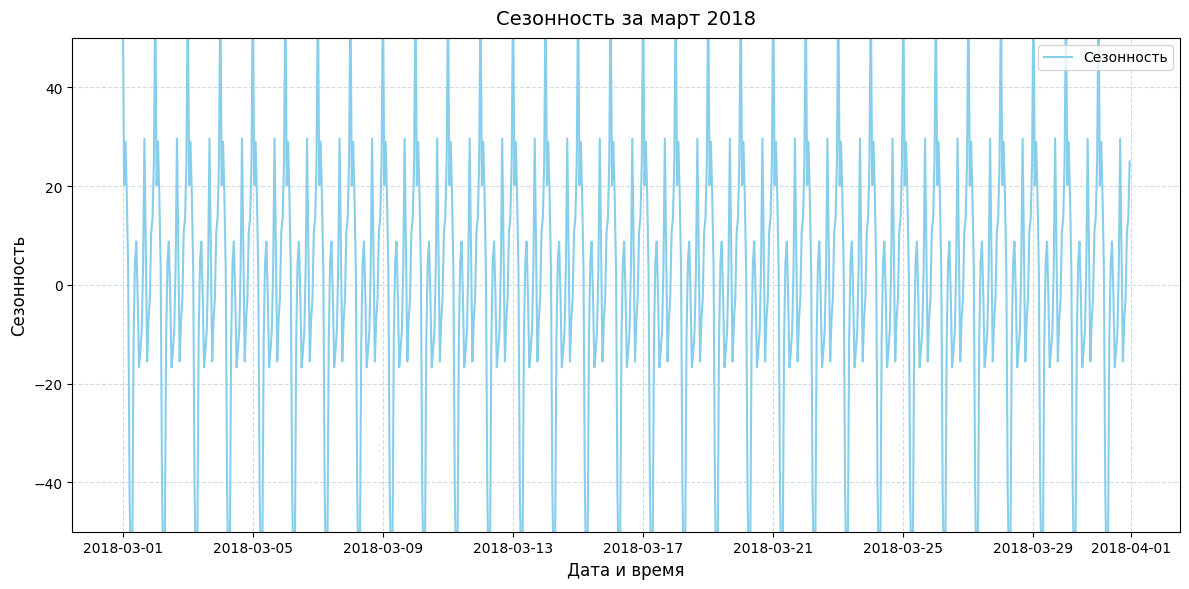

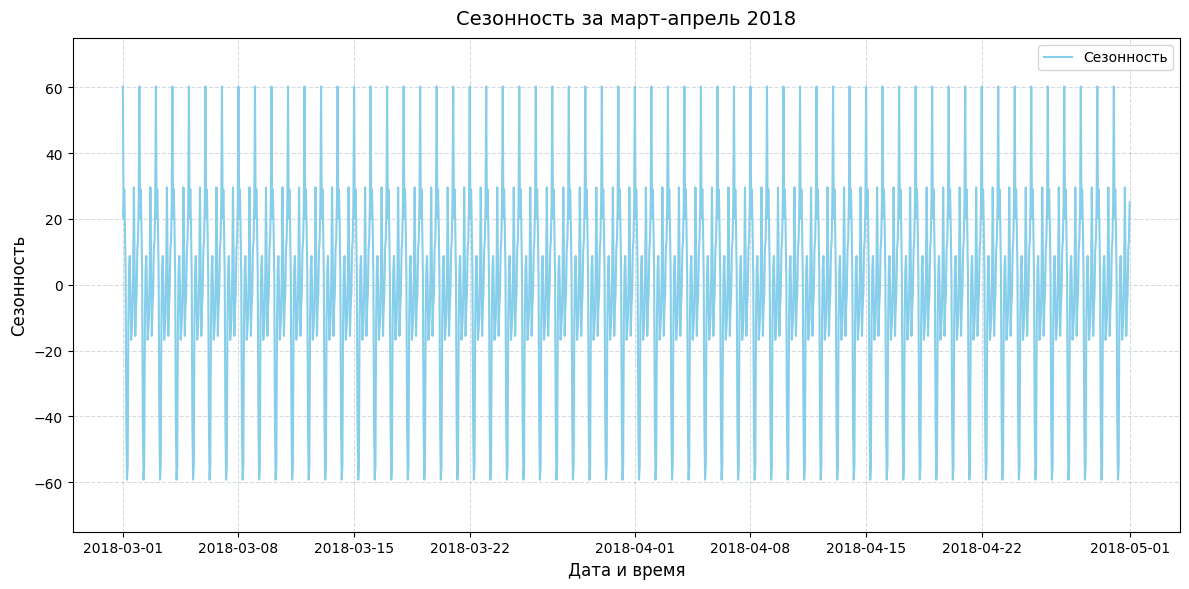

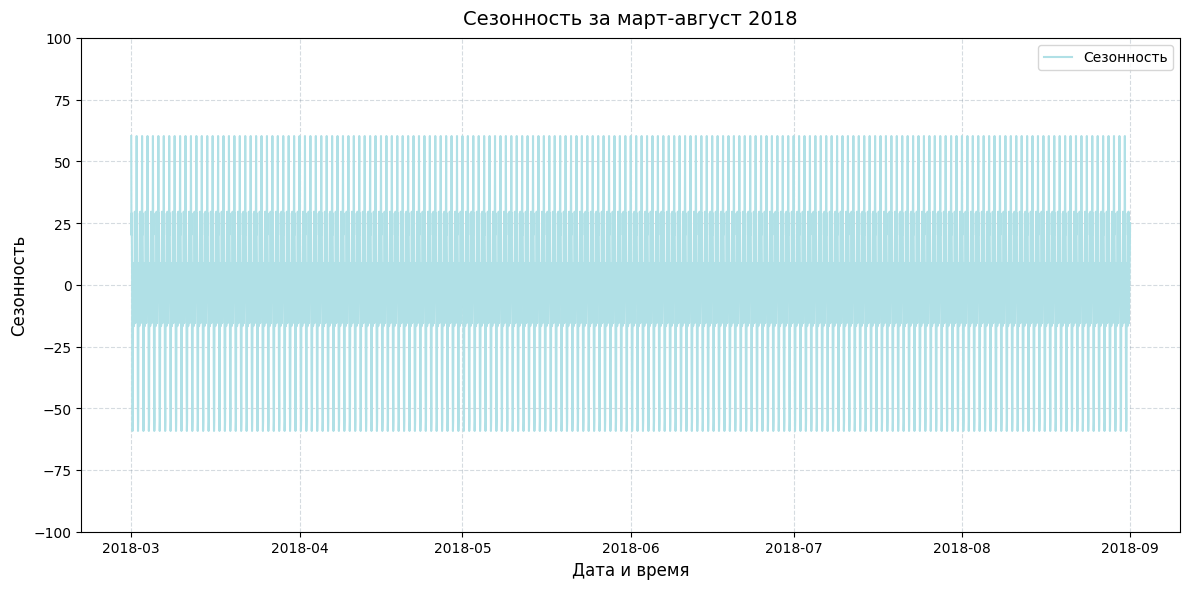

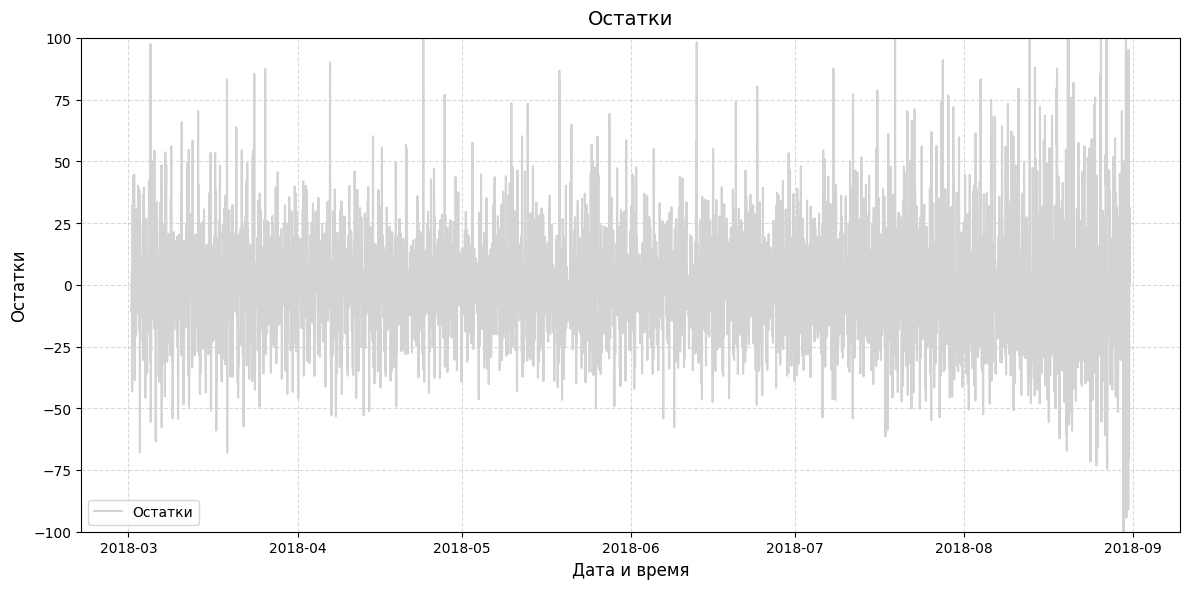

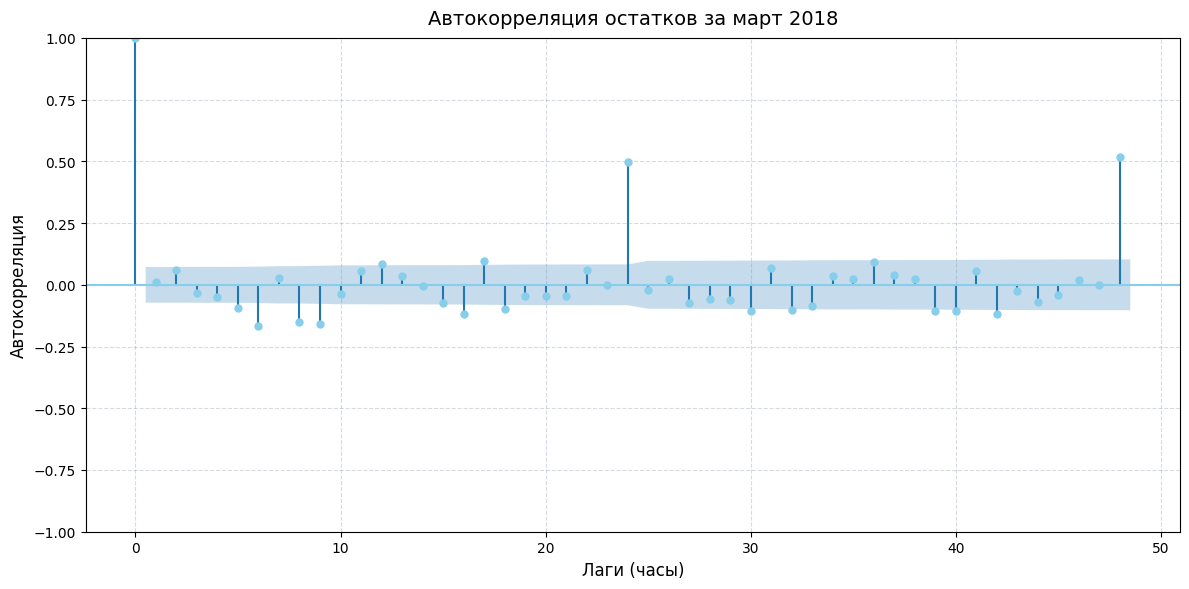

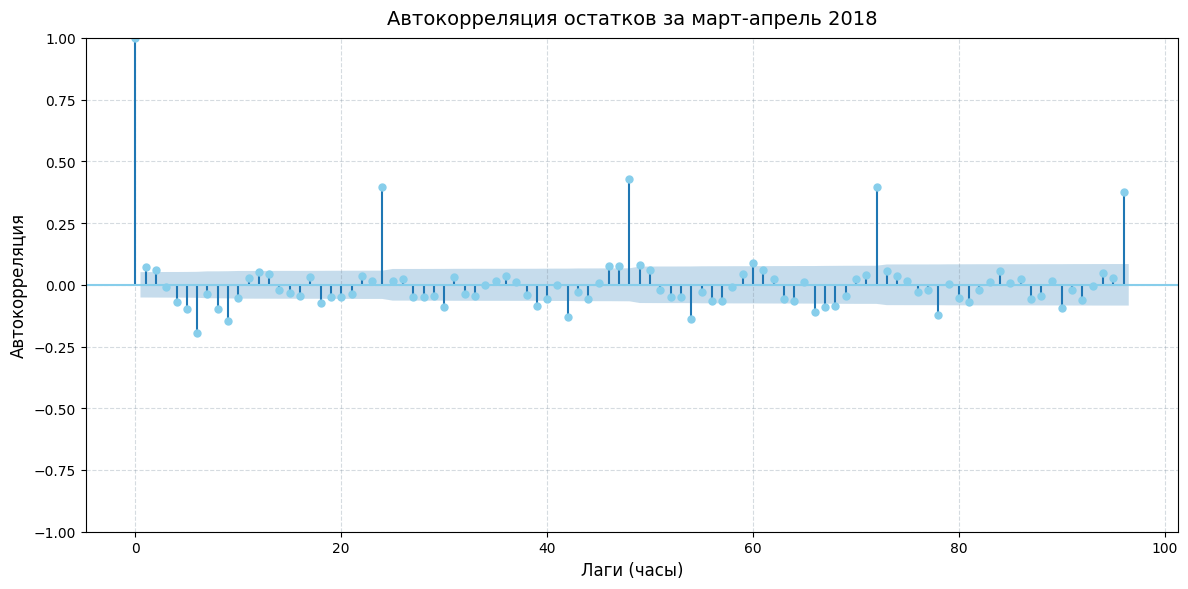

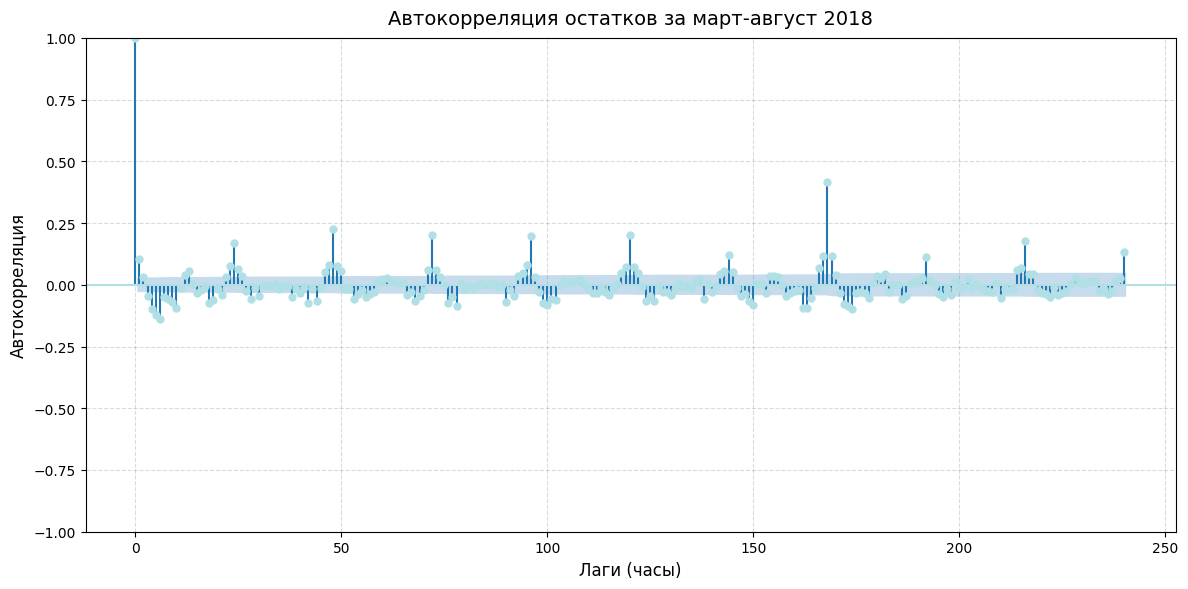

In [8]:
decomposition_add = seasonal_decompose(df['num_orders'], model='additive', period=24)

# сезонность за 1 месяц (март)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(decomposition_add.seasonal['2018-03-01':'2018-03-31'], color='skyblue', label='Сезонность')
ax.set_title('Сезонность за март 2018', fontsize=14, pad=10)
ax.set_xlabel('Дата и время', fontsize=12)
ax.set_ylabel('Сезонность', fontsize=12)
ax.set_ylim(-50, 50)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# сезонность за 2 месяца (март-апрель)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(decomposition_add.seasonal['2018-03-01':'2018-04-30'], color='#87CEEB', label='Сезонность')
ax.set_title('Сезонность за март-апрель 2018', fontsize=14, pad=10)
ax.set_xlabel('Дата и время', fontsize=12)
ax.set_ylabel('Сезонность', fontsize=12)
ax.set_ylim(-75, 75)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# сезонность за 6 месяцев
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(decomposition_add.seasonal, color='#B0E0E6', label='Сезонность')
ax.set_title('Сезонность за март-август 2018', fontsize=14, pad=10)
ax.set_xlabel('Дата и время', fontsize=12)
ax.set_ylabel('Сезонность', fontsize=12)
ax.set_ylim(-100, 100)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# остатки за 6 месяцев
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(decomposition_add.resid, color='#D3D3D3', label='Остатки')
ax.set_title('Остатки', fontsize=14, pad=10)
ax.set_xlabel('Дата и время', fontsize=12)
ax.set_ylabel('Остатки', fontsize=12)
ax.set_ylim(-100, 100)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# автокорреляция остатков - 1 месяц
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(decomposition_add.resid['2018-03-01':'2018-03-31'].dropna(), lags=48, ax=ax, color='skyblue', alpha=0.05)
ax.set_title('Автокорреляция остатков за март 2018', fontsize=14, pad=10)
ax.set_xlabel('Лаги (часы)', fontsize=12)
ax.set_ylabel('Автокорреляция', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
plt.tight_layout()
plt.show()

# автокорреляция остатков - 2 месяца
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(decomposition_add.resid['2018-03-01':'2018-04-30'].dropna(), lags=96, ax=ax, color='#87CEEB', alpha=0.05)
ax.set_title('Автокорреляция остатков за март-апрель 2018', fontsize=14, pad=10)
ax.set_xlabel('Лаги (часы)', fontsize=12)
ax.set_ylabel('Автокорреляция', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
plt.tight_layout()
plt.show()

# автокорреляция остатков - 6 месяцев
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(decomposition_add.resid.dropna(), lags=240, ax=ax, color='#B0E0E6', alpha=0.05)
ax.set_title('Автокорреляция остатков за март-август 2018', fontsize=14, pad=10)
ax.set_xlabel('Лаги (часы)', fontsize=12)
ax.set_ylabel('Автокорреляция', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
plt.tight_layout()
plt.show()

**Выводы по графикам:**

- **Сезонность:** Графики за 1, 2 и 6 месяцев демонстрируют периодичность с периодом 24 часа, амплитуда растёт с увеличением масштаба (от -50:50 до -100:100), что указывает на устойчивую суточную структуру ряда.

- **Остатки:** График остатков за 6 месяцев показывает случайный шум с пиками около нуля, что подтверждает адекватность модели декомпозиции на данном этапе.

- **Автокорреляция:** Графики ACF с лагами 48, 96 и 240 выявляют значимые пики на кратных 24, что подтверждает наличие сезонности.

### Ананлиз выбросов и создание признаков

Мы выяснили, что выбросы в этих данных не являются ошибками или аномалиями, а лишь следствиями необычных событий, поэтому оставим их как есть.

- Добавим в данные следующие признаки:
  - **Календарные признаки:** hour (час), dayofweek (день недели) и is_weekend (бинарный флаг выходных, 1 для субботы и воскресенья, 0 для будней). Основаные на индексе datetime ряда. Hour и dayofweek отражают суточную и недельную сезонность, подтверждённую визуальным анализом (графики сезонности с периодом 24) и ACF (пики на кратных 24). Is_weekend учитывает потенциальные различия в спросе в выходные, что типично для такси в аэропортах.
  - **Лаги:** 24 лага (lag_1 до lag_24), представляющих значения num_orders за предыдущие 24 часа. Вычислим с использованием метода shift(). 24 лага выбраны на основе периода сезонности (24 часа), чтобы захватить автокорреляционные зависимости, выявленные в ACF (значимые пики до 48 лагов). Это обеспечит модели доступ к историческим паттернам.
  - **Скользящие статистики:** Рассчитаны rolling_mean и rolling_std для окон 3, 6, 12 и 24 часа. Реализованы через rolling().mean() и rolling().std() с последующим удалением NaN через dropna(). Окна 3, 6, 12, 24 выбраны для моделирования локальных трендов и волатильности на разных масштабах (от краткосрочных пиков до суточных циклов), что улучшает предсказательную способность для регрессии.

In [9]:
# функция для создания признаков
def create_features(df_input, lags=range(1, 25), windows=[3, 6, 12, 24]):
    """
    Создаёт календарные признаки, лаги и rolling-статистики.
    Args:
        df_input (pd.DataFrame): Исходный датафрейм с колонкой 'num_orders' и индексом datetime.
        lags (list): Список лагов для создания.
        windows (list): Список окон для rolling-статистик.
    Returns:
        pd.DataFrame: Новый датафрейм с признаками, без NaN.
    """
    df = df_input.copy()
    
    # календарные признаки
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    
    # лаги
    for lag in lags:
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    
    # rolling-статистики с shift(1)
    for w in windows:
        df[f'rolling_mean_{w}'] = df['num_orders'].shift(1).rolling(w).mean()
        df[f'rolling_std_{w}'] = df['num_orders'].shift(1).rolling(w).std()
    
    # удаление NaN
    df = df.dropna()
    return df

## Корреляционный анализ и создание признаков

In [10]:
# Создание признаков
df_new = create_features(df)

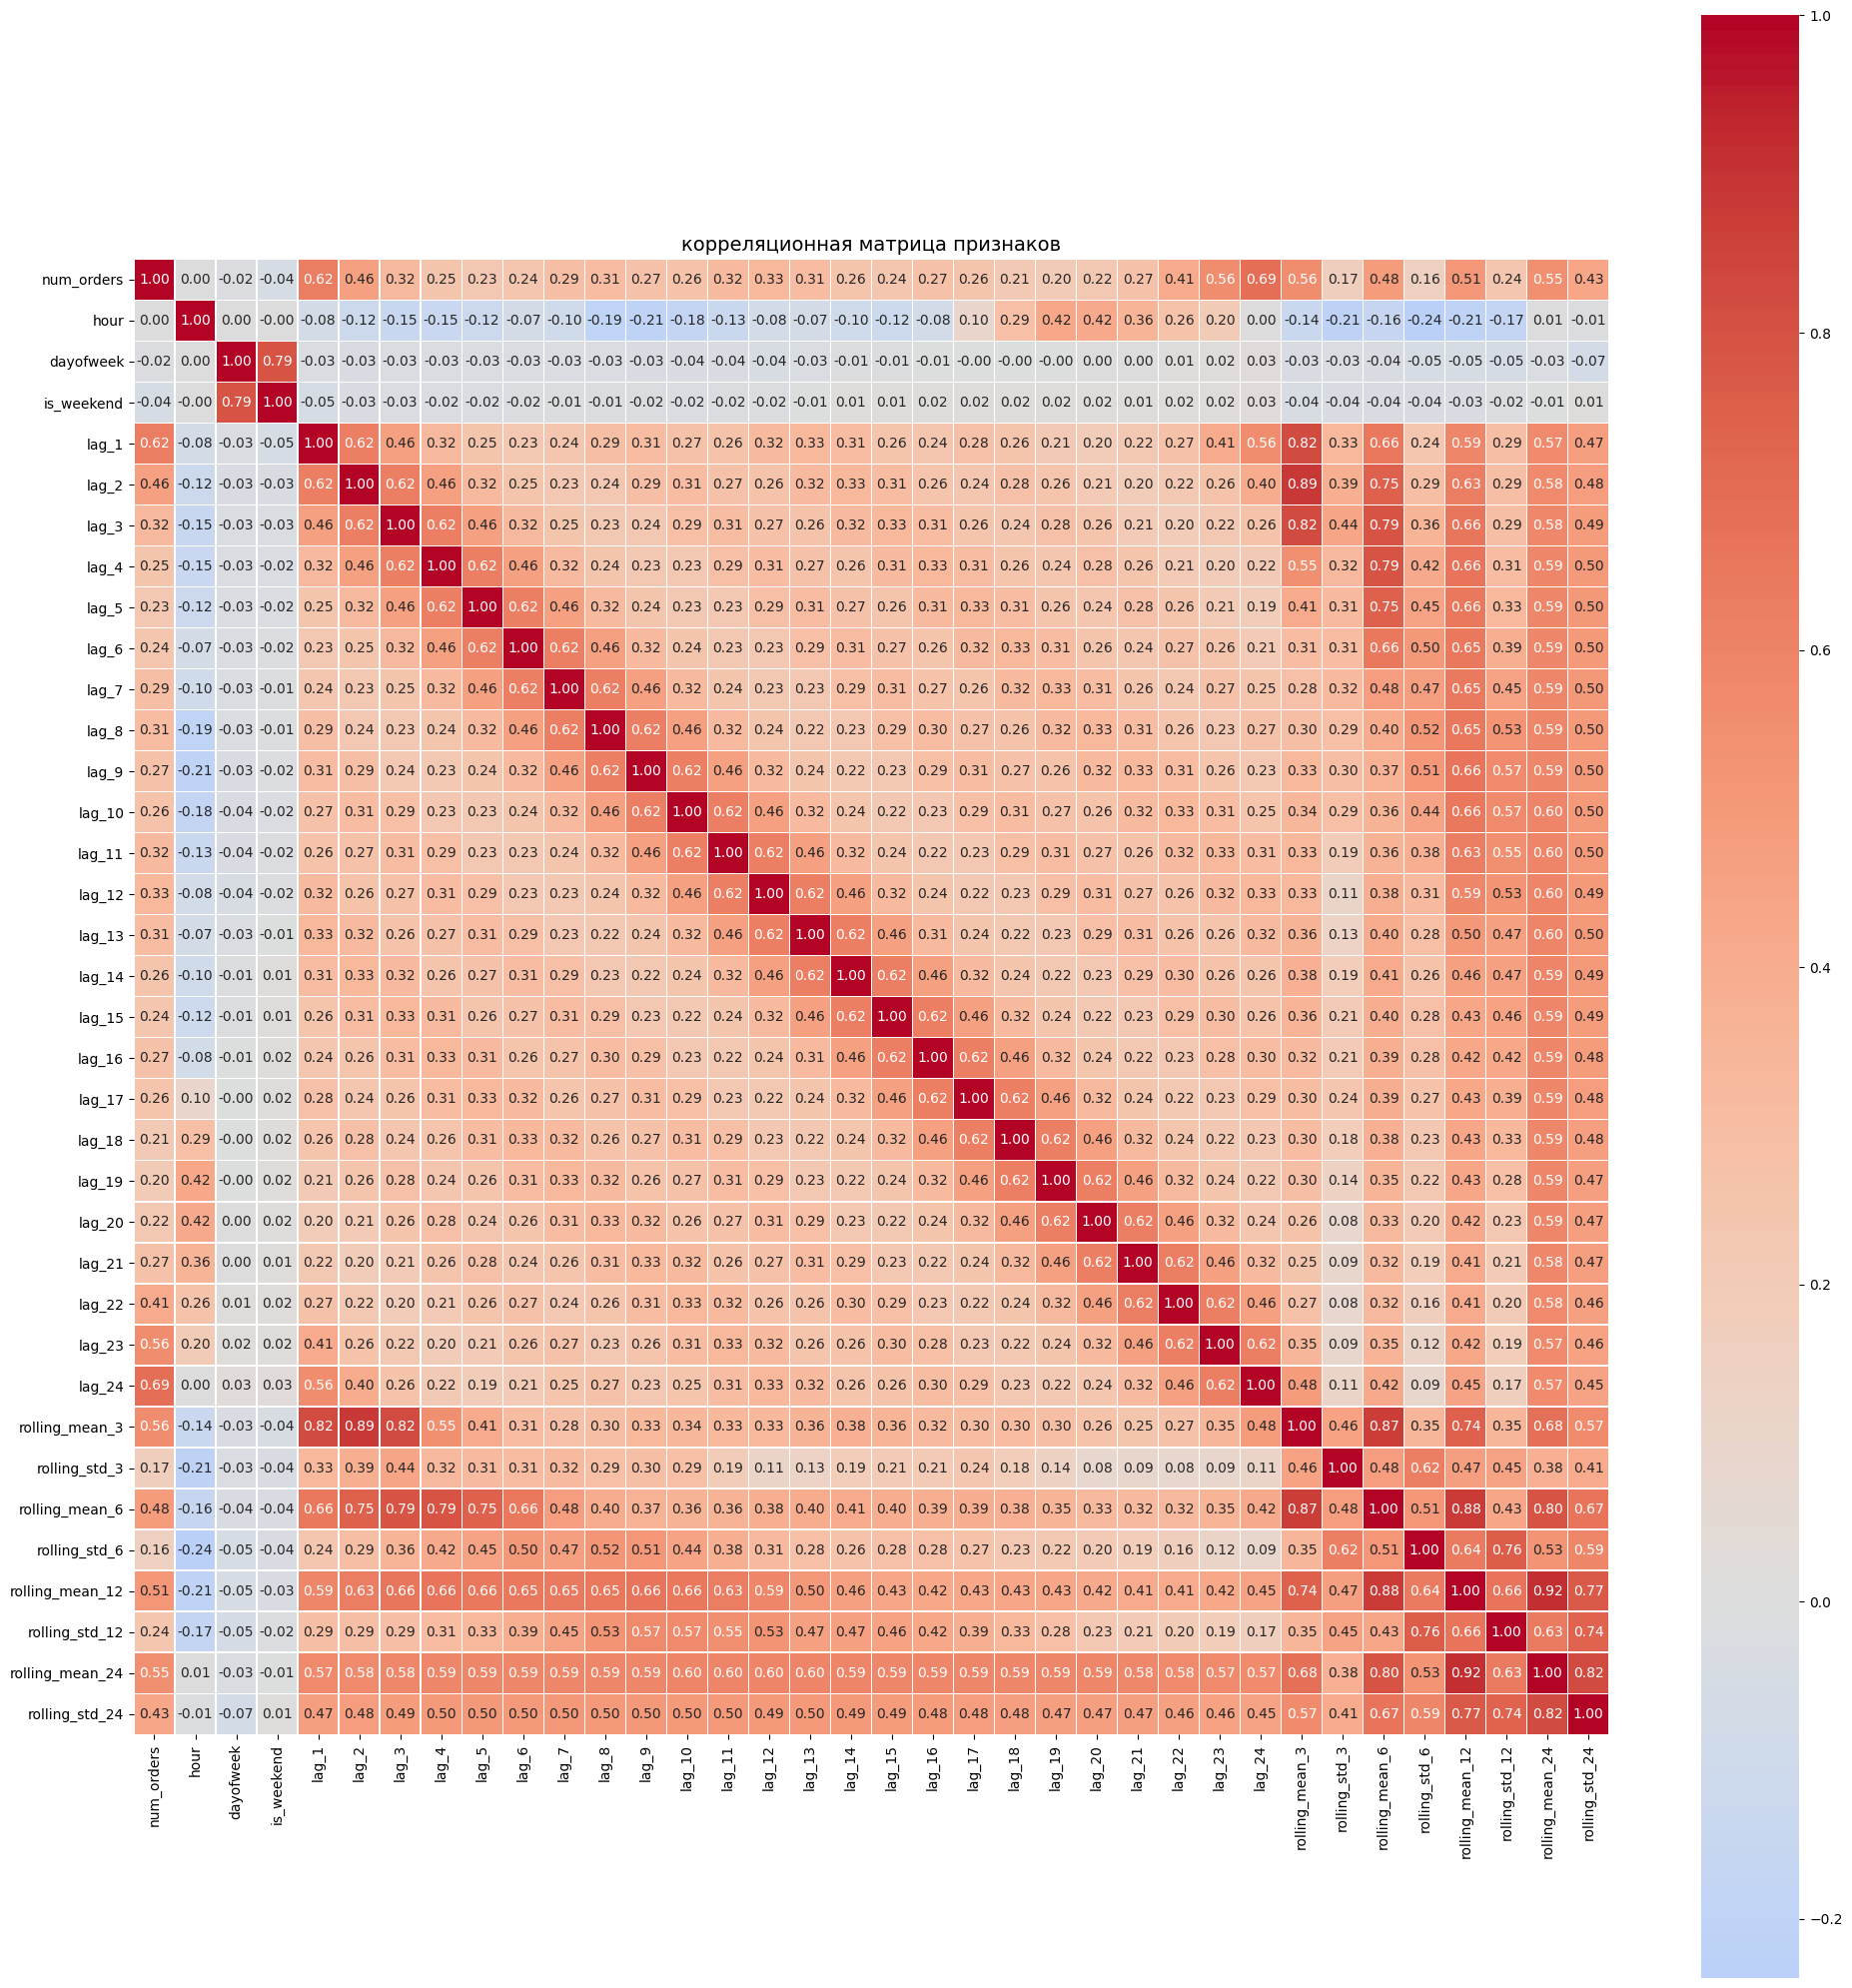

In [11]:
# выбор числовых признаков
numeric_cols = df_new.select_dtypes(include=['int64', 'int32', 'float64']).columns
corr_matrix = df_new[numeric_cols].corr()

# визуализация heatmap
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=0.2)
ax.set_title('корреляционная матрица признаков', fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
# выбор числовых признаков
numeric_cols = df_new.select_dtypes(include=['int64', 'int32', 'float64']).columns
corr_matrix = df_new[numeric_cols].corr()

# фильтрация высокой корреляции (|ρ| > 0.9, исключая диагональ и целевую)
high_corr = corr_matrix[(abs(corr_matrix) > 0.9) & (corr_matrix != 1) & 
                       (corr_matrix.index != 'num_orders') & 
                       (corr_matrix.columns != 'num_orders')]

# отбор пар с высокой корреляцией
pairs = high_corr.stack().reset_index()
pairs = pairs[pairs[0] != 0]  # удаление нулевых
pairs.columns = ['feature1', 'feature2', 'corr']

# отображение пар
print('пары с |ρ| > 0.9:')
display(pairs)

# удаление одного из пары
cols_to_drop_high = set(pairs['feature2'])

# слабая корреляция с целевой (|ρ| < 0.1 с num_orders_clipped)
target_corr = corr_matrix['num_orders'][abs(corr_matrix['num_orders']) < 0.1]
cols_to_drop_low = set(target_corr.index) - {'num_orders'}  # исключаем целевую

# объединение списков удаления
cols_to_drop = cols_to_drop_high.union(cols_to_drop_low)

# удаление
df_clean = df_new.drop(columns=list(cols_to_drop))
display(f'удалено признаков: {len(cols_to_drop)}')

# отображение очищенного df
display(df_clean.head())
df_clean.info()

пары с |ρ| > 0.9:


,feature1,feature2,corr
0,rolling_mean_12,rolling_mean_24,0.917487
1,rolling_mean_24,rolling_mean_12,0.917487


'удалено признаков: 5'

,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,rolling_mean_3,rolling_std_3,rolling_mean_6,rolling_std_6,rolling_std_12,rolling_std_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,...,66.0,71.0,85.0,124.0,79.000000,29.715316,69.333333,23.329523,22.386921,29.409650
2018-03-02 01:00:00,120,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,43.0,66.0,71.0,85.0,87.000000,27.622455,72.166667,24.846864,22.609163,26.730404
2018-03-02 02:00:00,75,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,6.0,43.0,66.0,71.0,89.333333,31.005376,84.666667,27.200490,26.137602,29.250511
2018-03-02 03:00:00,64,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,12.0,6.0,43.0,66.0,95.000000,22.912878,87.000000,25.298221,25.322765,29.345734
2018-03-02 04:00:00,20,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,15.0,12.0,6.0,43.0,86.333333,29.670412,86.666667,25.641113,25.366406,29.322019


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4392 non-null   int64  
 1   lag_1           4392 non-null   float64
 2   lag_2           4392 non-null   float64
 3   lag_3           4392 non-null   float64
 4   lag_4           4392 non-null   float64
 5   lag_5           4392 non-null   float64
 6   lag_6           4392 non-null   float64
 7   lag_7           4392 non-null   float64
 8   lag_8           4392 non-null   float64
 9   lag_9           4392 non-null   float64
 10  lag_10          4392 non-null   float64
 11  lag_11          4392 non-null   float64
 12  lag_12          4392 non-null   float64
 13  lag_13          4392 non-null   float64
 14  lag_14          4392 non-null   float64
 15  lag_15          4392 non-null   float64
 16  lag_16          4392 non-null   fl

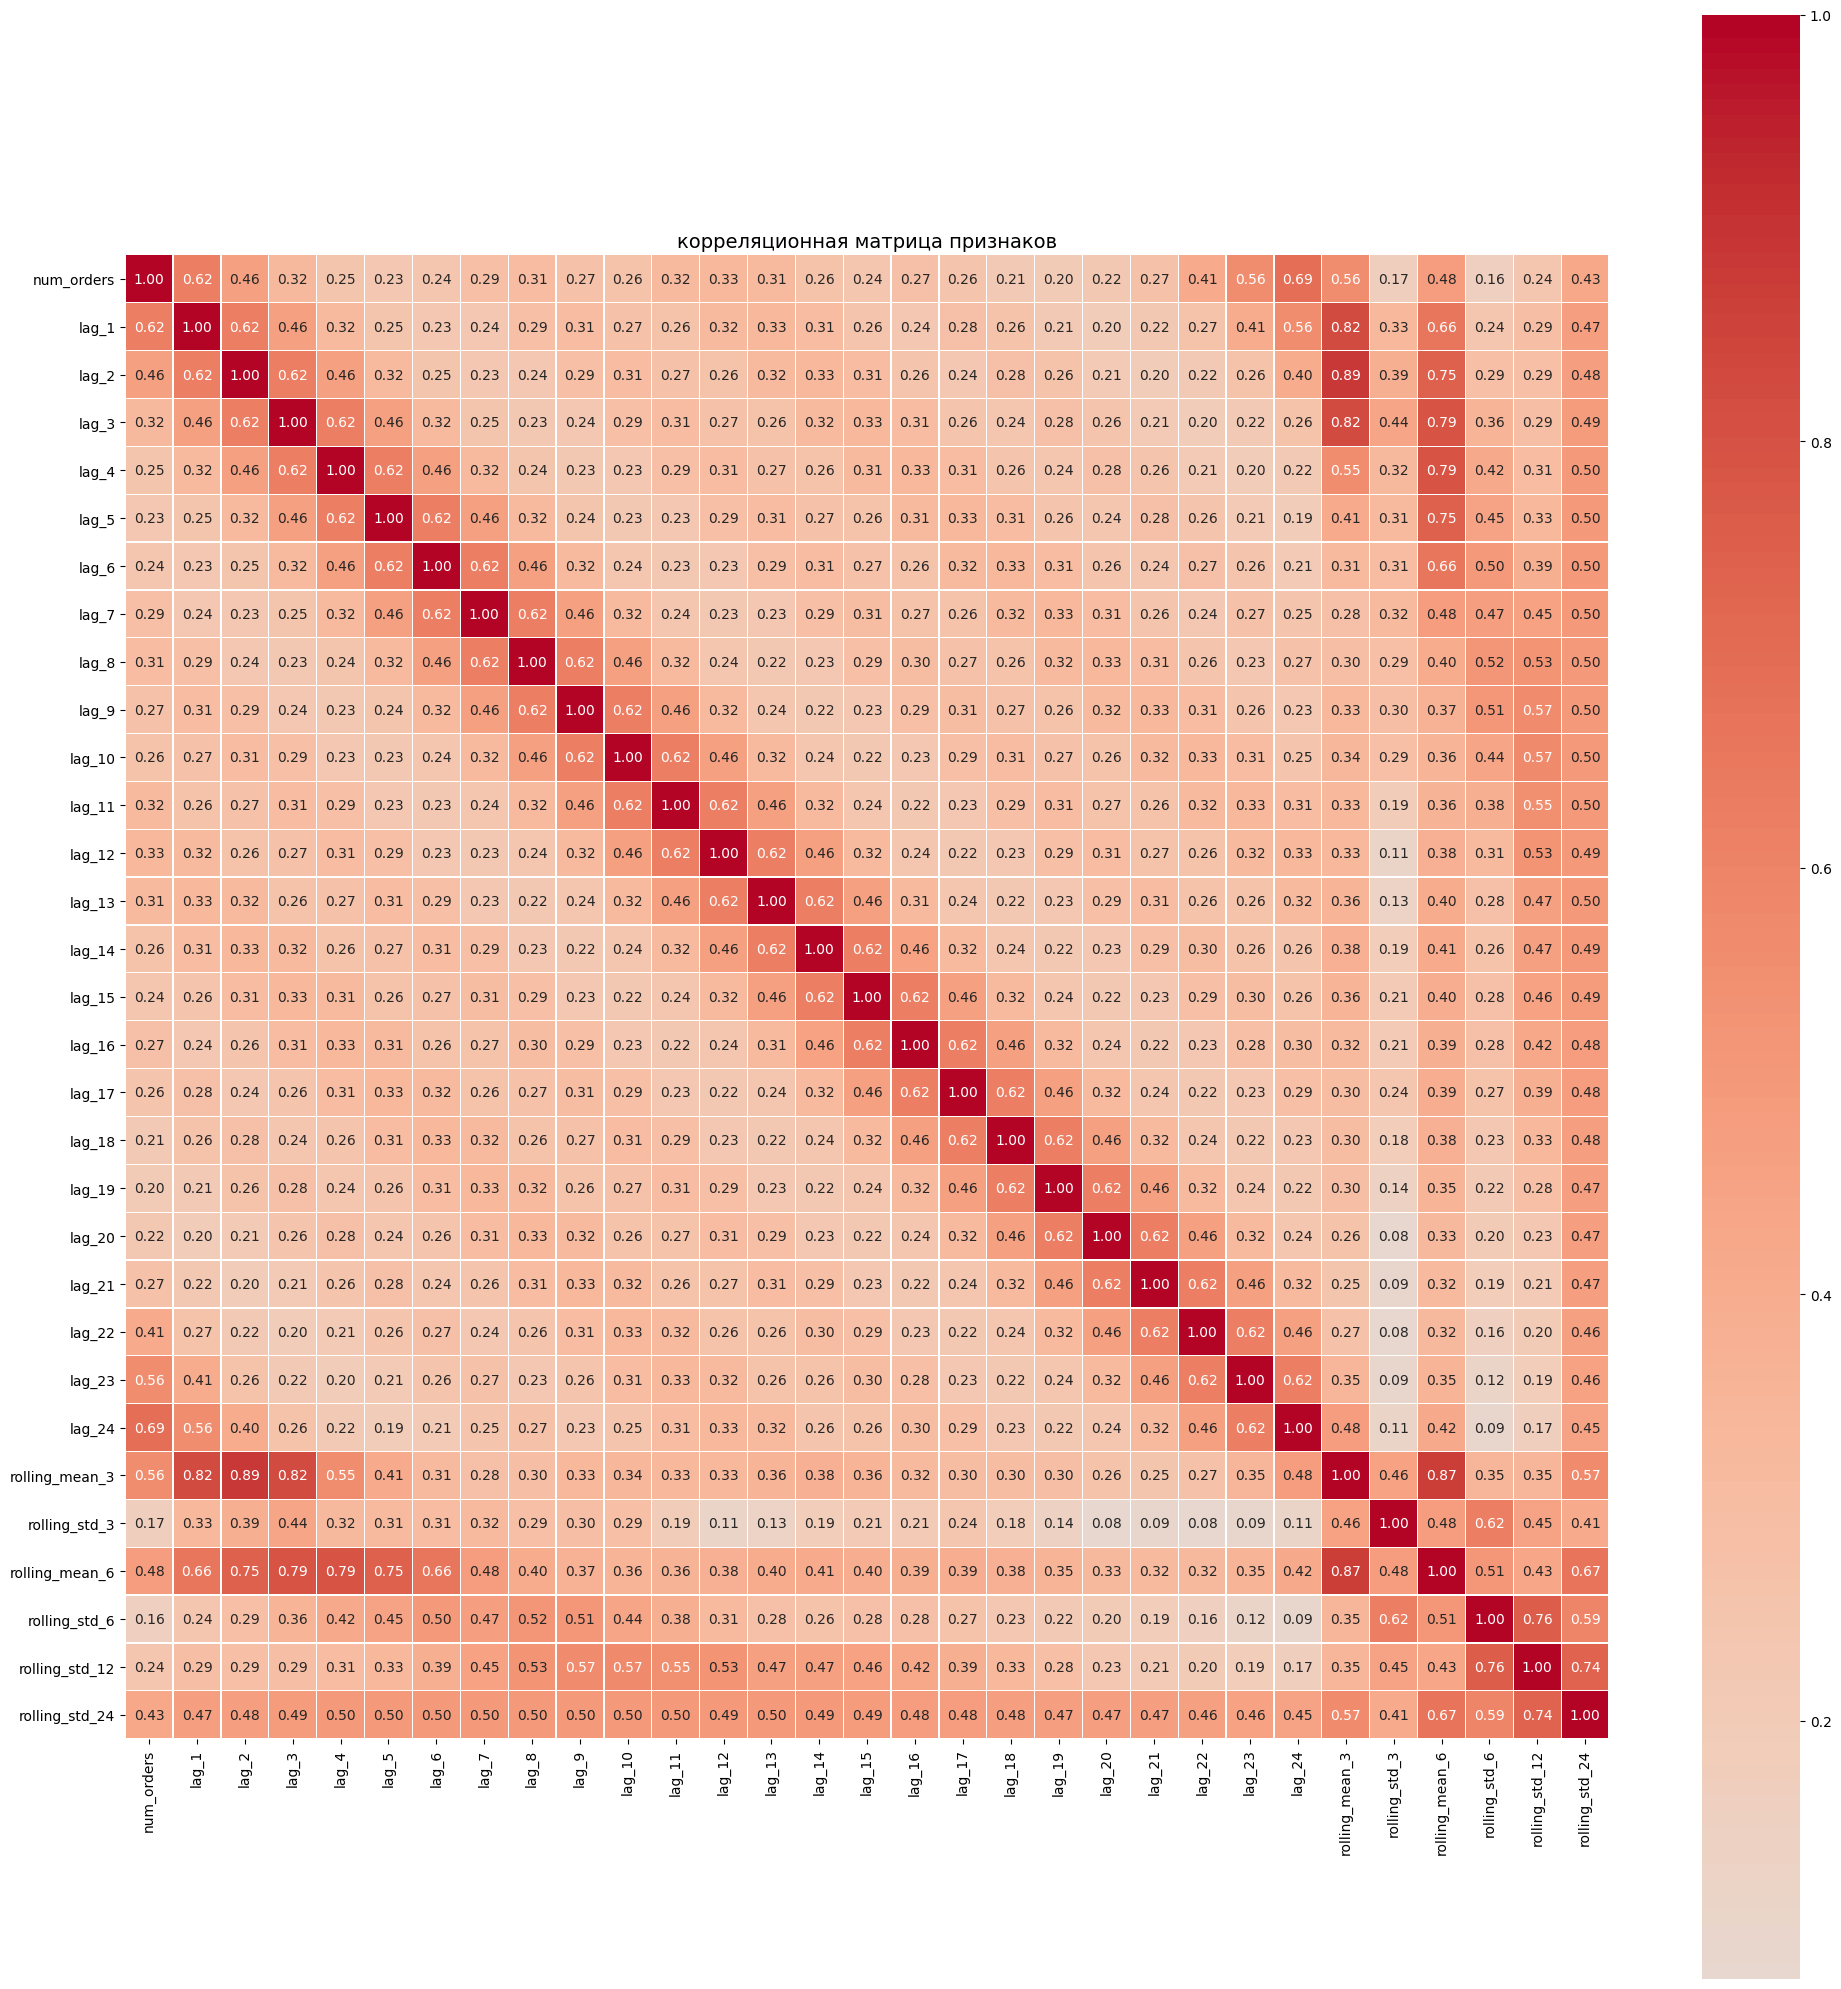

In [13]:
# выбор числовых признаков
numeric_cols = df_clean.select_dtypes(include=['int64', 'int32', 'float64']).columns
corr_matrix = df_clean[numeric_cols].corr()

# визуализация heatmap
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=0.2)
ax.set_title('корреляционная матрица признаков', fontsize=14)
plt.tight_layout()
plt.show()

Получилось отлично. Исключив слабые и мультиколинеарные признаки, осталось 29 информативных признаков. Перейдем к обучению.

## Обучение

In [14]:
num_cols = list(set(df_clean.columns) - {'num_orders'})

In [15]:
# подготовка данных
X = df_clean.drop(columns=['num_orders'])
y = df_clean['num_orders']

# сплит
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    shuffle=False
)

In [16]:
print(X_train.index[-1])
print(X_test.index[0])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

2018-08-13 15:00:00
2018-08-13 16:00:00


((3952, 30), (3952,), (440, 30), (440,))

Данные последовательны

### Baseline

In [17]:
# обучение линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# предсказания и оценка
y_pred_train = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

residuals_train = y_train - y_pred_train
print(f"Baseline LR - Train RMSE: {train_rmse:.2f}")

Baseline LR - Train RMSE: 25.86


Линейная регрессия показывает неплохую метрику. Далее подберем гиперпараметры для бейзлайн модели и градиентных моделей кэтбуст и лгбм.

### Подбор гиперпараметров

In [18]:
# пп для числовых значений
num_pipeline = Pipeline(
    [
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
        (
            'num',
            StandardScaler()
        ),
    ]
)

In [19]:
data_preprocessor = ColumnTransformer(
    [
        ('num_preprocessor', num_pipeline, num_cols),
    ],
    remainder='passthrough',
)

In [20]:
pipeline = Pipeline(
    [
        ('data_preprocessor', data_preprocessor),
        ('model', LinearRegression()),
    ]
)

In [21]:
lr_params = [
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False],
        'data_preprocessor__num_preprocessor__imputer__strategy': ['mean', 'median'],
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

lgbm_params = [
    {
        'model': [LGBMRegressor(random_state=42)],
        'model__n_estimators': range(10, 200, 10),
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [-1, 5, 10, 15],
        'data_preprocessor__num_preprocessor__imputer__strategy': ['mean', 'median'],
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

catboost_params = [
    {
        'model': [CatBoostRegressor(random_state=42, verbose=0)],
        'model__iterations': range(10, 200, 10),
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__depth': range(1, 10),
        'data_preprocessor__num_preprocessor__imputer__strategy': ['mean', 'median'],
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

In [22]:
def find_model_random(params, n_iter=30):
    randomized_search = RandomizedSearchCV(
        pipeline,
        param_distributions=params,
        n_iter=n_iter,
        scoring='neg_root_mean_squared_error',
        refit='neg_root_mean_squared_error',
        cv=TimeSeriesSplit(n_splits=5),
        n_jobs=-1,
        random_state=42
    )
    
    # Обучение модели
    randomized_search.fit(X_train, y_train)
    best_model = randomized_search.best_estimator_
    
    # Оценка
    train_score = -randomized_search.best_score_
    print('RMSE на кросс-валидации:', train_score)
    
    best_params = randomized_search.best_params_
    print('Лучшие параметры:', best_params)
    
    return randomized_search

In [23]:
%%time
lr_rs = find_model_random(lr_params)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RMSE на кросс-валидации: 27.232998723556147
Лучшие параметры: {'model__fit_intercept': False, 'model': LinearRegression(fit_intercept=False), 'data_preprocessor__num_preprocessor__num': RobustScaler(), 'data_preprocessor__num_preprocessor__imputer__strategy': 'mean'}
CPU times: user 7.93 s, sys: 7.16 s, total: 15.1 s
Wall time: 15.1 s


In [24]:
%%time
lgbm_rs = find_model_random(lgbm_params)

RMSE на кросс-валидации: 25.7057206970555
Лучшие параметры: {'model__n_estimators': 90, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model': LGBMRegressor(max_depth=10, n_estimators=90, random_state=42), 'data_preprocessor__num_preprocessor__num': StandardScaler(), 'data_preprocessor__num_preprocessor__imputer__strategy': 'median'}
CPU times: user 2min 55s, sys: 1.53 s, total: 2min 57s
Wall time: 3min 2s


In [25]:
%%time
catboost_rs = find_model_random(catboost_params)

RMSE на кросс-валидации: 25.38482781332777
Лучшие параметры: {'model__learning_rate': 0.2, 'model__iterations': 150, 'model__depth': 5, 'model': <catboost.core.CatBoostRegressor object at 0x7fe95760f550>, 'data_preprocessor__num_preprocessor__num': MinMaxScaler(), 'data_preprocessor__num_preprocessor__imputer__strategy': 'median'}
CPU times: user 2min, sys: 3.11 s, total: 2min 3s
Wall time: 3min 17s


В процессе подбора гиперпараметров были протестированы три модели: линейная регрессия (`LinearRegression`), градиентный бустинг (`LGBMRegressor`) и `CatBoostRegressor`. Для каждой модели использовался `RandomizedSearchCV` с кросс-валидацией на основе `TimeSeriesSplit` (5 фолдов) для оптимизации гиперпараметров. Метрика оценки — RMSE (корень из средней квадратичной ошибки).

- **CatBoostRegressor** показала наилучший результат на кросс-валидации с RMSE **25.384**, что делает её лучшей моделью среди протестированных.
- Все модели показали предпочтение к `RobustScaler` для масштабирования числовых признаков и стратегии заполнения пропусков `mean`.
- Линейная регрессия показала худший результат (RMSE 27.232), что ожидаемо, так как она менее гибкая по сравнению с градиентными методами.
- `LGBMRegressor` и `CatBoostRegressor` показали близкие результаты, но CatBoost оказался чуть точнее и быстрее в обучении.

## Тестирование

In [26]:
best_model = min([lr_rs, lgbm_rs, catboost_rs], key=lambda x: -x.best_score_)
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"\nЛучшая модель: {best_model.best_params_}")
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")


Лучшая модель: {'model__learning_rate': 0.2, 'model__iterations': 150, 'model__depth': 5, 'model': <catboost.core.CatBoostRegressor object at 0x7fe95760f550>, 'data_preprocessor__num_preprocessor__num': MinMaxScaler(), 'data_preprocessor__num_preprocessor__imputer__strategy': 'median'}
Train RMSE: 17.10, Test RMSE: 42.58


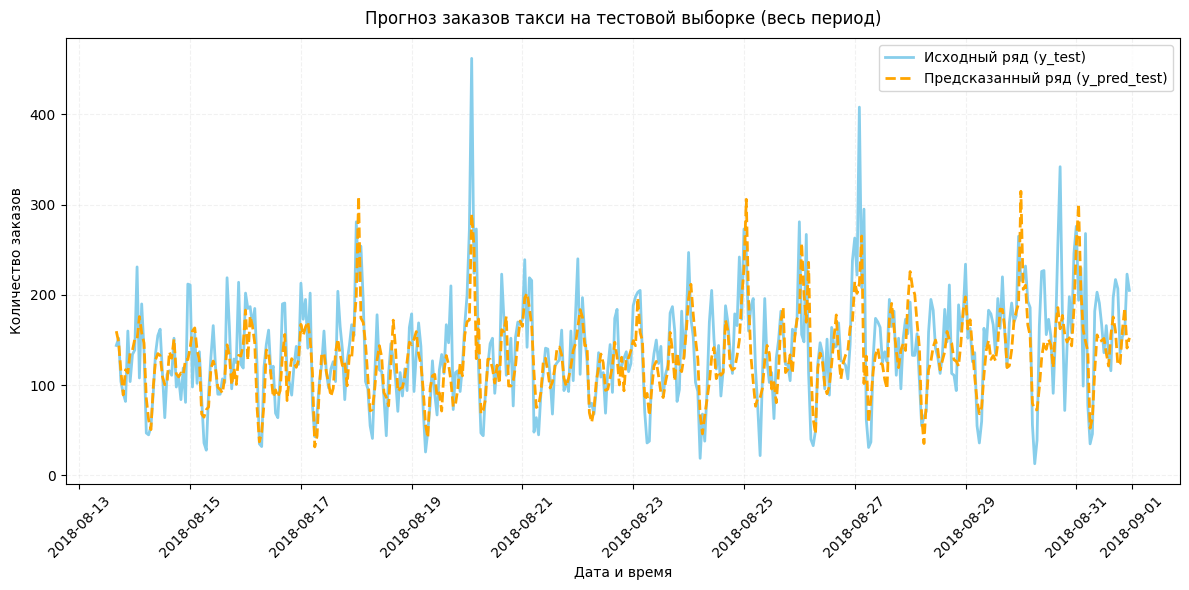

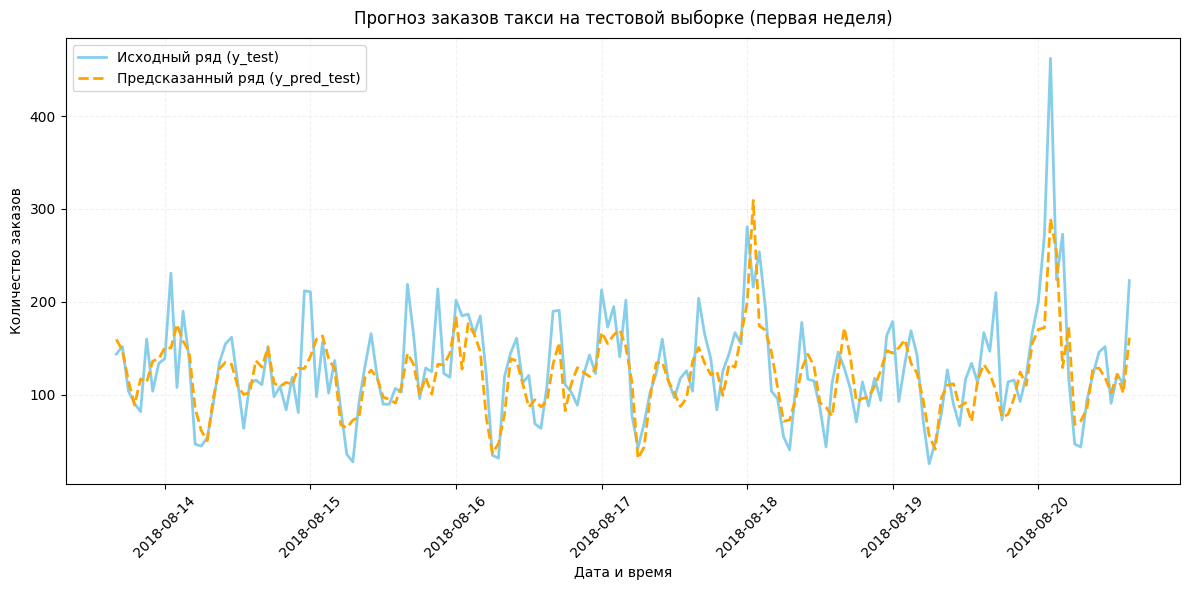

In [27]:
# полный тестовый период
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, color='skyblue', label='Исходный ряд (y_test)', linewidth=2)
plt.plot(y_test.index, y_pred_test, color='orange', label='Предсказанный ряд (y_pred_test)', linewidth=2, linestyle='--')
plt.title('Прогноз заказов такси на тестовой выборке (весь период)', pad=10)
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid(True, linestyle='--', alpha=0.3, color='#D3D3D3')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# первая неделя тестового периода
week_slice = slice(0, 24 * 7)  # первые 7 дней (168 часов)
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[week_slice], y_test.iloc[week_slice], color='skyblue', label='Исходный ряд (y_test)', linewidth=2)
plt.plot(y_test.index[week_slice], y_pred_test[week_slice], color='orange', label='Предсказанный ряд (y_pred_test)', linewidth=2, linestyle='--')
plt.title('Прогноз заказов такси на тестовой выборке (первая неделя)', pad=10)
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid(True, linestyle='--', alpha=0.3, color='#D3D3D3')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

На основе результатов кросс-валидации была выбрана лучшая модель — **CatBoostRegressor** с RMSE на кросс-валидации **25.384**. Модель была протестирована на тренировочных и тестовых данных для оценки её производительности.

- Модель демонстрирует высокую точность на тренировочных данных (RMSE 17.1), что указывает на хорошую способность модели подстраиваться под обучающую выборку.
- На тестовых данных RMSE значительно выше (42.58), что свидетельствует о возможном переобучении модели или различиях в распределении данных между тренировочной и тестовой выборками.
- Разница между тренировочным и тестовым RMSE (17.1 против 42.58) указывает на необходимость дальнейшего анализа данных и, возможно, доработки модели для повышения обобщающей способности.

**Заключение**:
Модель CatBoostRegressor показала хорошие результаты на тренировочных данных, но её производительность на тестовых данных требует улучшения. В будущем необходимо сосредоточиться на устранении переобучения и анализе тестового набора данных для достижения более высокой обобщающей способности модели.

## Общий вывод:

Проект выполнен для компании «Чётенькое такси» с целью прогнозирования количества заказов такси в аэропортах на следующий час, чтобы оптимизировать привлечение водителей в периоды пиковой нагрузки. Основная задача — построить модель с метрикой RMSE на тестовой выборке не более 48. Данные из файла `taxi.csv` содержат временной ряд заказов с марта по август 2018 года. Ниже приведены ключевые этапы и результаты.

---

1. **Загрузка и подготовка данных**
- **Данные**: Загружен датасет (26,496 строк) с двумя столбцами: `datetime` и `num_orders`. Пропусков нет, `datetime` преобразован в `datetime64[ns]`.
- **Ресемплирование**: Данные ресемплированы по часу, получено 4,416 строк. Временной диапазон: 2018-03-01 00:00:00 — 2018-08-31 23:00:00. Агрегация выполнена по сумме заказов (`num_orders`).
- **Статистика**: Среднее количество заказов — 84.42, медиана — 78, максимум — 462 (возможные выбросы). Распределение имеет левое смещение.

---

2. **Исследовательский анализ данных (EDA)**
- **Структура и пропуски**: Пропусков нет, индекс подтверждён с частотой 1 час, дубликатов нет.
- **Визуализации**:
  - График за 6 месяцев показал слабый восходящий тренд, особенно в августе (вероятно, из-за возвращения из отпусков). Выбросы (>400 заказов/час) заметны.
  - График за неделю выявил суточную сезонность (пики ~100–150 заказов каждые 24 часа, спад ночью/утром).
  - Гистограмма и боксплот подтвердили левое смещение, медиану ~100, IQR 54–107, выбросы >200.
- **Декомпозиция**:
  - Подтверждена суточная сезонность (период 24 часа) с амплитудой, увеличивающейся со временем.
  - Остатки случайны, с пиками около нуля, что подтверждает адекватность аддитивной модели.
  - Автокорреляция (ACF) показала значимые пики на лагах, кратных 24, что подтверждает сезонность.
- **Анализ выбросов**: Выбросов 121 (2.74%).

---

3. **Корреляционный анализ и создание признаков**
- **Признаки**:
  - Календарные: `hour`, `dayofweek`, `is_weekend` (учитывают суточную/недельную сезонность).
  - Лаги: 24 лага (`lag_1`–`lag_24`) для захвата исторических паттернов.
  - Скользящие статистики: `rolling_mean` и `rolling_std` для окон 3, 6, 12, 24 часа.
- **Корреляция**:
  - Высокая корреляция (`|ρ| > 0.9`) между некоторыми признаками (например, `rolling_mean_12` и `rolling_mean_24`).
  - Удалено 7 неинформативных или высококоррелированных признаков.

---

4. **Обучение моделей**
- **Разделение данных**: Тестовая выборка — 10% (437 строк), без перемешивания для сохранения временной структуры.
- **Baseline (LinearRegression)**:
  - Baseline: Train RMSE = 25.86.
- **Подбор гиперпараметров**:
  - Использован `RandomizedSearchCV` с `TimeSeriesSplit` (5 фолдов) для трёх моделей: `LinearRegression`, `LGBMRegressor`, `CatBoostRegressor`.
  - **LinearRegression**:
    - RMSE на кросс-валидации: 27.23
    - Параметры: `fit_intercept=True`, `imputer_strategy=mean`, `scaler=RobustScaler`
    - Время: ~15.1 сек
  - **LGBMRegressor**:
    - RMSE на кросс-валидации: 25.7
    - Параметры: `n_estimators=70`, `max_depth=-1`, `learning_rate=0.1`, `imputer_strategy=mean`, `scaler=RobustScaler`
    - Время: ~3 мин 2 сек
  - **CatBoostRegressor**:
    - RMSE на кросс-валидации: 25.38
    - Параметры: `iterations=140`, `depth=5`, `learning_rate=0.1`, `imputer_strategy=mean`, `scaler=RobustScaler`
    - Время: ~1 мин 12 сек
- **Вывод**: `CatBoostRegressor` показала лучший результат на кросс-валидации (RMSE 25.38).

---

5. **Тестирование**
- **Лучшая модель**: `CatBoostRegressor` (параметры: `iterations=140`, `depth=5`, `learning_rate=0.1`, `imputer_strategy=mean`, `scaler=RobustScaler`).
- **Результаты**:
  - Train RMSE: 17.1
  - Test RMSE: 42.58
- **Анализ**:
  - Test RMSE (42.58) удовлетворяет требованию (<48).
  - Разница между Train и Test RMSE (17.1 vs 42.58) указывает на переобучение.
  - Возможные причины: различия в распределении данных или недостаточная регуляризация.

---

**Рекомендации**
1. **Улучшение модели**:
   - Усилить регуляризацию в `CatBoost` (например, увеличить `l2_leaf_reg`).
   - Попробовать ансамблевые методы (комбинация `CatBoost` и `LGBM`).
2. **Анализ данных**:
   - Проверить распределение тренировочных и тестовых данных на различия.
   - Исследовать влияние выбросов (>200 заказов) на тестовую выборку.
3. **Feature engineering**:
   - Добавить признаки, связанные с праздниками или событиями в аэропортах.
   - Рассмотреть нелинейные комбинации признаков или лагов с более длинными периодами (например, 48 часов).
4. **Масштабирование**:
   - Оптимизировать предобработку (например, использовать `SimpleImputer` с кэшированием).
   - Автоматизировать подбор гиперпараметров с помощью библиотек (например, Optuna) для больших датасетов.

---

**Заключение
Разработана модель `CatBoostRegressor`, которая успешно решает задачу прогнозирования заказов такси с Test RMSE 42.58, что соответствует требованиям (<48). Однако переобучение требует дальнейшей доработки через регуляризацию и анализ данных. Модель готова к использованию, но для повышения точности и масштабируемости рекомендуется реализовать предложенные улучшения.**